In [1]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass  # Do nothing with the file paths

In [2]:
import cv2
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def apply_gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def apply_edge_detection(image):
    return cv2.Canny(image, 100, 200)

def extract_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error reading image: {image_path}")
        return None, None
    image = apply_gaussian_blur(image)
    sift = cv2.SIFT_create(nfeatures=5000, contrastThreshold=0.04, edgeThreshold=10)
    kp, des = sift.detectAndCompute(image, None)  # Use the blurred image directly
    if des is None:
        print(f"No descriptors found for image: {image_path}")
    return kp, des

In [4]:
def extract_dataset_features_and_labels(dataset_dir, max_images_per_class=2000//7, fixed_size=1000):
    features = []
    labels = []

    # Get the list of class labels
    class_labels = os.listdir(dataset_dir)
    
    # Filter out non-directory items
    class_labels = [label for label in class_labels if os.path.isdir(os.path.join(dataset_dir, label))]

    # Iterate through each class
    for label in class_labels:
        class_dir = os.path.join(dataset_dir, label)
        print(f"Processing class: {label}")  # Debugging line

        image_count = 0  # Counter to keep track of processed images for this class

        for image_file in os.listdir(class_dir):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_path = os.path.join(class_dir, image_file)
                kp, des = extract_features(image_path)
                if des is not None:
                    # Limit the number of descriptors to fixed_size
                    if des.shape[0] > fixed_size:
                        des = des[:fixed_size, :]
                    elif des.shape[0] < fixed_size:
                        # Pad descriptors to fixed_size
                        padding = np.zeros((fixed_size - des.shape[0], des.shape[1]))
                        des = np.vstack([des, padding])

                    # Flatten the descriptor and append to features
                    features.append(des.flatten())
                    labels.append(label)

                    image_count += 1

                    if image_count >= max_images_per_class:  # Stop after max_images_per_class
                        break
        print(f"Finished processing class: {label} with {image_count} images.")  # Debugging line

    print(f"Total features: {len(features)}")
    print(f"Labels: {np.unique(labels)}")  # Debugging line
    return np.array(features), np.array(labels)

In [5]:
train_dir = '/kaggle/input/fairface-race/FairFace Race/train'
val_dir = '/kaggle/input/fairface-race/FairFace Race/val'

train_features, train_labels = extract_dataset_features_and_labels(train_dir)
val_features, val_labels = extract_dataset_features_and_labels(val_dir)

print(f"Unique train labels: {np.unique(train_labels)}")
print(f"Unique validation labels: {np.unique(val_labels)}")

Processing class: Black
Finished processing class: Black with 285 images.
Processing class: Latino_Hispanic
Finished processing class: Latino_Hispanic with 285 images.
Processing class: White
Finished processing class: White with 285 images.
Processing class: East Asian
Finished processing class: East Asian with 285 images.
Processing class: Southeast Asian
Finished processing class: Southeast Asian with 285 images.
Processing class: Middle Eastern
Finished processing class: Middle Eastern with 285 images.
Processing class: Indian
Finished processing class: Indian with 285 images.
Total features: 1995
Labels: ['Black' 'East Asian' 'Indian' 'Latino_Hispanic' 'Middle Eastern'
 'Southeast Asian' 'White']
Processing class: Black
Finished processing class: Black with 285 images.
Processing class: Latino_Hispanic
Finished processing class: Latino_Hispanic with 285 images.
Processing class: White
Finished processing class: White with 285 images.
Processing class: East Asian
Finished processin

In [6]:
train_features, train_labels = extract_dataset_features_and_labels(train_dir)
val_features, val_labels = extract_dataset_features_and_labels(val_dir)

svm = SVC(kernel='linear')
svm.fit(train_features, train_labels)
print(train_features.shape, train_labels.shape)

Processing class: Black
Finished processing class: Black with 285 images.
Processing class: Latino_Hispanic
Finished processing class: Latino_Hispanic with 285 images.
Processing class: White
Finished processing class: White with 285 images.
Processing class: East Asian
Finished processing class: East Asian with 285 images.
Processing class: Southeast Asian
Finished processing class: Southeast Asian with 285 images.
Processing class: Middle Eastern
Finished processing class: Middle Eastern with 285 images.
Processing class: Indian
Finished processing class: Indian with 285 images.
Total features: 1995
Labels: ['Black' 'East Asian' 'Indian' 'Latino_Hispanic' 'Middle Eastern'
 'Southeast Asian' 'White']
Processing class: Black
Finished processing class: Black with 285 images.
Processing class: Latino_Hispanic
Finished processing class: Latino_Hispanic with 285 images.
Processing class: White
Finished processing class: White with 285 images.
Processing class: East Asian
Finished processin

Validation Accuracy: 15.54%
Model saved to svm_model.pkl
Confusion Matrix:
[[60 35 38 39 36 38 39]
 [43 38 34 49 41 37 43]
 [47 36 52 39 36 39 36]
 [45 44 51 44 36 31 34]
 [37 44 40 39 46 45 34]
 [42 52 40 44 35 33 39]
 [48 37 32 43 47 41 37]]


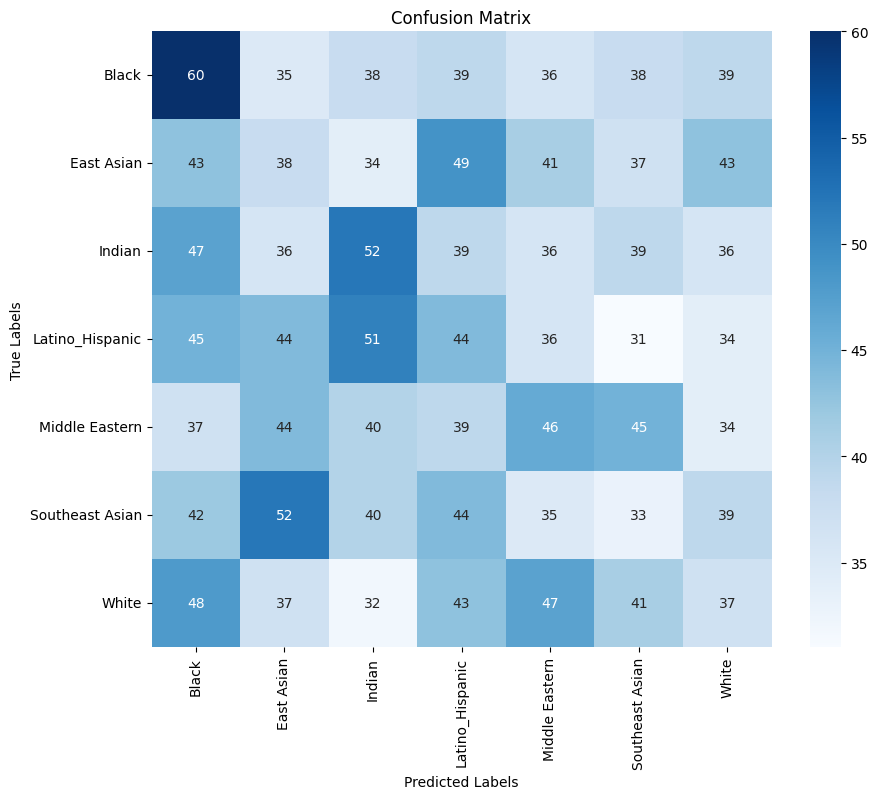

Classification Report:
                 precision    recall  f1-score   support

          Black       0.19      0.21      0.20       285
     East Asian       0.13      0.13      0.13       285
         Indian       0.18      0.18      0.18       285
Latino_Hispanic       0.15      0.15      0.15       285
 Middle Eastern       0.17      0.16      0.16       285
Southeast Asian       0.12      0.12      0.12       285
          White       0.14      0.13      0.14       285

       accuracy                           0.16      1995
      macro avg       0.15      0.16      0.15      1995
   weighted avg       0.15      0.16      0.15      1995



In [7]:
val_predictions = svm.predict(val_features)
accuracy = accuracy_score(val_labels, val_predictions)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

joblib.dump(svm, 'svm_model.pkl')
print('Model saved to svm_model.pkl')

cm = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(val_labels), yticklabels=np.unique(val_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(val_labels, val_predictions))